In [ ]:
import sys
sys.path.append("..")

import pandas as pd 
from channeling_lib import AWS_file_loader, save_figure, load_path, load_aws_calibration_data, compute_t_stat, mean_wind_direction
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xarray as xr
import numpy as np
from scipy.stats import pearsonr
import seaborn as sns
import re




# Specify general folder:
aws_Cal_path = load_path()+'CalibratedData/AWS/'
arome_path = load_path()+ 'ModelOutput/AromeArctic/'


stations_str = ['Tom Joad','Rosanna','Bette Davis', 'Layla', 'Mrs Robinson']
# FROM LOW TO HIGH
stations_to_plot = ["Layla", "Rosanna"]  # For pressure only

# color_idx = ['#440154', '#3b528b', '#21918c', '#5ec962', '#fde725']
color_idx = ['#440154', '#3b528b', '#21918c', '#5ec962', '#b38a00']


instrument_textbook_name = load_path()+'instrument_textbook_BLcourse_spring2025(BL instruments).csv'
instrument_textbook_data = pd.read_csv(instrument_textbook_name, encoding='latin1')

In [2]:
# Load all AWS calibrated data
aws_Cal_data = load_aws_calibration_data(aws_Cal_path, stations_str)

# Load AromeArctic Data
aromeArctic_data = xr.load_dataset(arome_path + 'AromeArctic_2p5km_MERGED_during_storm.nc')

type(aws_Cal_data['Bette Davis'])

pandas.core.frame.DataFrame

In [3]:
aws_hourly_data = {}

for i, station in enumerate(stations_str):
    aws_hourly_data[station] = aws_Cal_data[station].resample('h').mean()
    # Add a column for station name
    aws_hourly_data[station]['Station'] = station 
    aws_hourly_data[station]['wind_direction'] = aws_Cal_data[station].wind_direction.resample('h').apply(mean_wind_direction)



In [4]:
def match_data_length(model_data, actual_data):
    """
    Ensures model_data and actual_data have the same length by trimming the longer one.

    Parameters:
    - model_data: Pandas Series, NumPy array, or xarray DataArray.
    - actual_data: Pandas Series.

    Returns:
    - Trimmed model_data and actual_data with matching length.
    """

    # Convert model data if it's an xarray DataArray
    if isinstance(model_data, xr.DataArray):
        model_data = model_data.to_series()

    # Ensure both are Pandas Series (if they are not NumPy arrays)
    if isinstance(model_data, np.ndarray):
        model_data = pd.Series(model_data)
    if isinstance(actual_data, np.ndarray):
        actual_data = pd.Series(actual_data)

    # Align time index if necessary
    if isinstance(model_data, pd.Series) and isinstance(actual_data, pd.Series):
        # Intersect indices to ensure alignment
        common_index = model_data.index.intersection(actual_data.index)
        model_data = model_data.loc[common_index]
        actual_data = actual_data.loc[common_index]

    # Find the minimum length
    min_length = min(len(model_data), len(actual_data))

    # Trim both datasets
    model_data = model_data.iloc[:min_length]
    actual_data = actual_data.iloc[:min_length]

    return model_data, actual_data


Function to generate comparative plots

In [5]:
# old function to generale plots

# def plot_timeseries(variable, selection):
#     """
#     Plots time series of AWS and model data for a given variable and stores the results.
    
#     Parameters:
#     - variable (str): One of "temperature", "wind_speed", "wind_direction", "pressure".
#     - selection (str): "all" for all stations, or a specific station name.
    
#     Returns:
#     - results (dict): Dictionary containing model data, actual data, and anomalies for each station.
#     """
    
#     global aws_hourly_data, aromeArctic_data, instrument_textbook_data, color_idx, match_data_length

#     # Define all stations
#     all_stations = ['Tom Joad', 'Rosanna', 'Bette Davis', 'Layla', 'Mrs Robinson']
    
#     # Define stations for pressure
#     pressure_stations = ["Layla", "Rosanna"]
    
#     # Determine which stations to plot
#     if selection == "all":
#         stations = pressure_stations if variable == "pressure" else all_stations
#     else:
#         if selection not in all_stations:
#             raise ValueError(f"Invalid station name. Choose from {all_stations} or 'all'")
#         stations = [selection]

#     # Mapping variable names to dataset attributes
#     variable_mapping = {
#         "temperature": {
#             "aws_key": "temperature",
#             "arome_key": "air_temperature_2m",
#             "unit": "°C",
#             "convert": lambda x: x - 273.15,
#         },
#         "wind_speed": {
#             "aws_key": "calibrated_wind_speed",
#             "arome_key": "wind_speed_10m",
#             "unit": "m/s",
#             "convert": lambda x: x,
#         },
#         "wind_direction": {
#             "aws_key": "wind_direction",
#             "arome_key": "wind_direction_10m",
#             "unit": "°",
#             "convert": lambda x: x,
#         },
#         "pressure": {
#             "aws_key": "calibrated_air_pressure",
#             "arome_key": "surface_air_pressure",
#             "unit": "hPa",
#             "convert": lambda x: x / 100,
#         }
#     }

#     if variable not in variable_mapping:
#         raise ValueError(f"Invalid variable. Choose from {list(variable_mapping.keys())}")
    
#     aws_key = variable_mapping[variable]["aws_key"]
#     arome_key = variable_mapping[variable]["arome_key"]
#     unit = variable_mapping[variable]["unit"]
#     convert_func = variable_mapping[variable]["convert"]
    
#     results = {}
    
#     fig, axes = plt.subplots(len(stations), 1, figsize=(10, 3 * len(stations)), sharex=True)
#     if len(stations) == 1:
#         axes = [axes]
    
#     for i, station in enumerate(stations):
#         ax = axes[i]
        
#         station_data = instrument_textbook_data[instrument_textbook_data["Station name"] == station]
#         station_lat = station_data["LAT (dec deg)"].values[0]
#         station_lon = station_data["LON (dec deg)"].values[0]
        
#         abs_diff = np.abs(aromeArctic_data.latitude - station_lat) + np.abs(aromeArctic_data.longitude - station_lon)
#         abs_diff_np = abs_diff.values
#         y_idx, x_idx = np.unravel_index(np.argmin(abs_diff_np), abs_diff_np.shape)
        
#         timeseries = convert_func(aromeArctic_data[arome_key].isel(y=y_idx, x=x_idx))
#         model_data = timeseries.to_series()
#         actual_data = aws_hourly_data[station][aws_key]
#         model_data, actual_data = match_data_length(model_data, actual_data)
        
#         errors = model_data - actual_data
#         stats = compute_t_stat(errors)

#         r_value, _ = pearsonr(model_data, actual_data)
#         r_value = round(r_value, 2)
        
#         results[station] = {
#             "model_data": model_data,
#             "actual_data": actual_data,
#             "errors": errors,
#             "t-statistic": stats["tstat"],
#             "p-value": stats["pval"],
#             "r-value": r_value
#         }
        
#         model_std = round(np.std(model_data), 2)
#         actual_std = round(np.std(actual_data), 2)
        
#         ax.plot(model_data.index, model_data, label=f'AromeArctic Model', linewidth=1, color=color_idx[i], linestyle='dotted')
#         ax.plot(actual_data.index, actual_data, label=f'AWS Data', linewidth=1, color=color_idx[i], linestyle='-')
        
#         # stats_text = f"t-stat: {stats['tstat']:.2f}\np-val: {stats['pval']:.2e}\n \u03C3_Model: {model_std}\n \u03C3_Actual: {actual_std}"
#         # ax.text(1.02, 0.5, stats_text, transform=ax.transAxes, fontsize=10,
#         #         verticalalignment='center', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

#         stats_text = f"t-stat: {stats['tstat']:.2f}\n" \
#              f"p-val: {stats['pval']:.2e}\n" \
#              r"$\sigma_{\text{Model}}$: " f"{model_std}\n" \
#              r"$\sigma_{\text{Actual}}$: " f"{actual_std}\n" \
#              f'r-val: {r_value}'
    
#         ax.text(1.02, 0.5, stats_text, transform=ax.transAxes, fontsize=10,
#         verticalalignment='center', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

        
#         ax.set_xlabel("Date")
#         ax.set_ylabel(f"{variable.capitalize()} ({unit})")
#         ax.set_title(f"{station}")
#         ax.legend()
#         ax.grid()

#     fig.suptitle(f'Hourly Mean {variable.capitalize()} Timeseries', fontsize=16, fontweight='bold', y=0.92)
    
#     save_figure(fig, '../figs/', f'modelValidation_{variable}_{selection}')

#     return results

# stations_str = ['Tom Joad', 'Rosanna', 'Bette Davis', 'Layla', 'Mrs Robinson']
# stations_to_plot = ["Layla", "Rosanna"]  # For pressure only

# # Plot temperature for all stations
# temp_data = plot_timeseries("temperature", 'all')

# # Plot wind speed for all stations
# windSpeed_data = plot_timeseries("wind_speed", 'all')

# # Plot wind direction for all stations
# windDirection_data = plot_timeseries("wind_direction", 'all')

# # Plot pressure (automatically uses only Layla & Rosanna)
# pressure_data = plot_timeseries("pressure", 'all')  # Will internally use stations_to_plot



Wind Speed for arome arctic is modelled at 10 m. We take it down to 2 m

U_2 = WS * (2/10)^0.16

In [6]:
aromeArctic_data['wind_speed_10m'] = aromeArctic_data['wind_speed_10m']*(2/10)**0.16

<>:119: SyntaxWarning: invalid escape sequence '\o'
<>:119: SyntaxWarning: invalid escape sequence '\e'
<>:119: SyntaxWarning: invalid escape sequence '\o'
<>:119: SyntaxWarning: invalid escape sequence '\e'
C:\Users\alber\AppData\Local\Temp\ipykernel_21844\3348572449.py:119: SyntaxWarning: invalid escape sequence '\o'
  f'$\overline{{\epsilon}}$: {error_mean}\n'
C:\Users\alber\AppData\Local\Temp\ipykernel_21844\3348572449.py:119: SyntaxWarning: invalid escape sequence '\e'
  f'$\overline{{\epsilon}}$: {error_mean}\n'


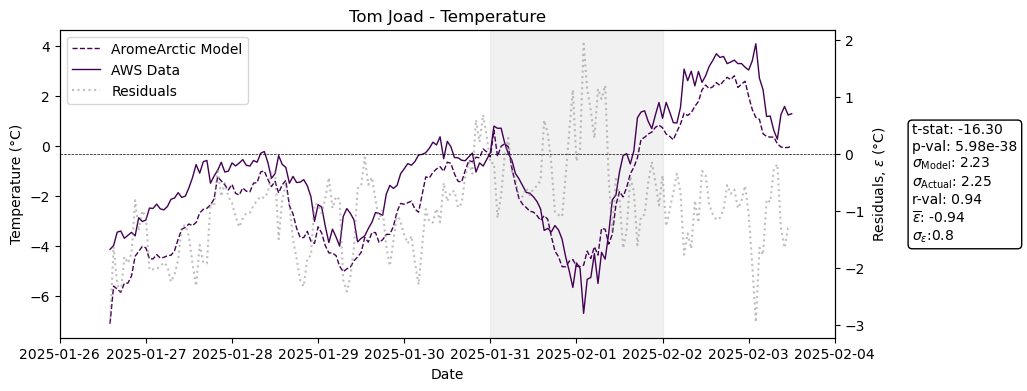

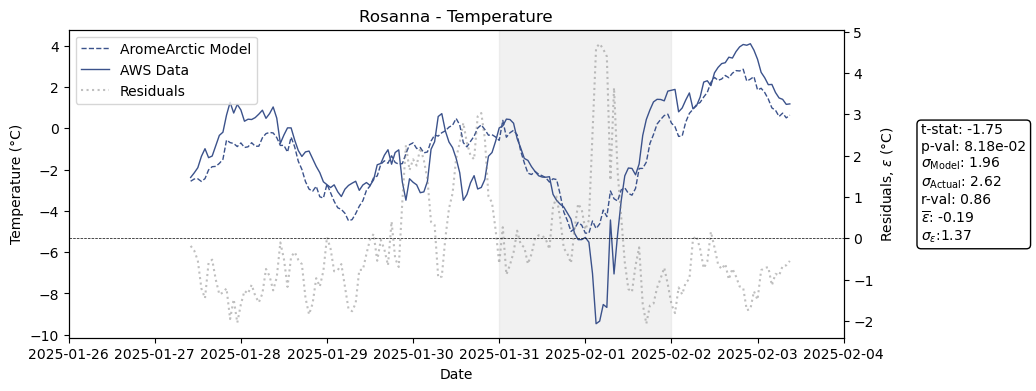

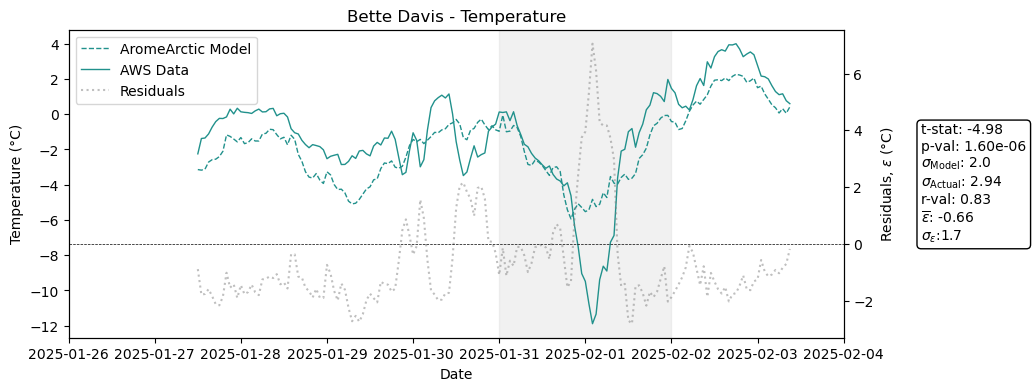

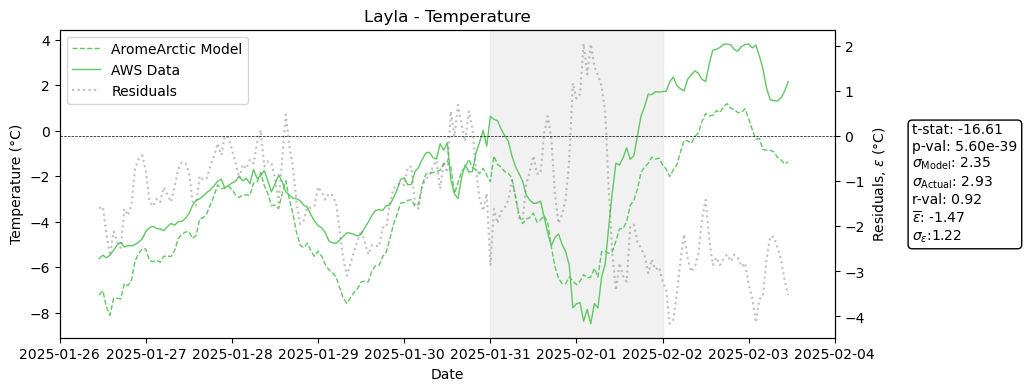

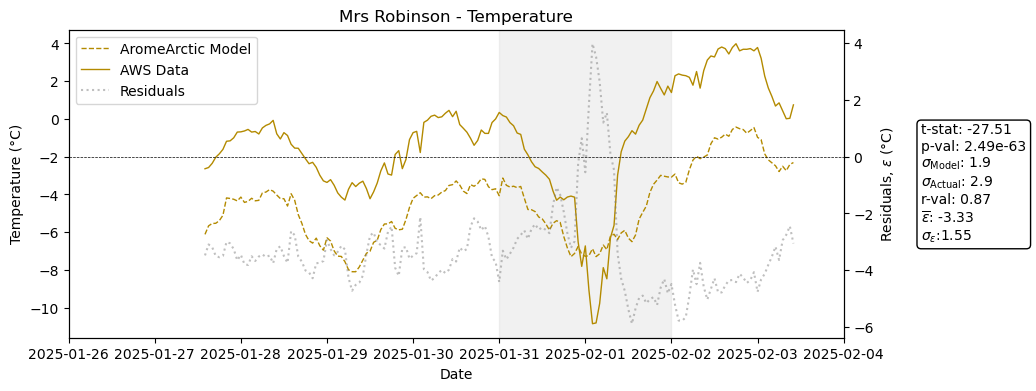

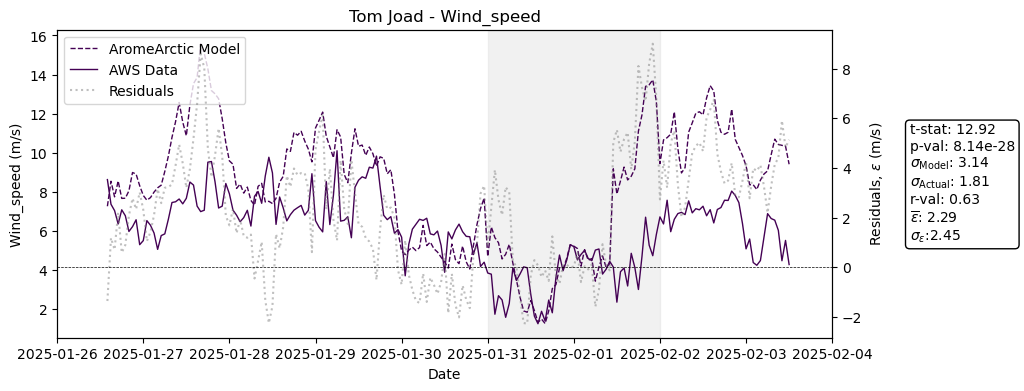

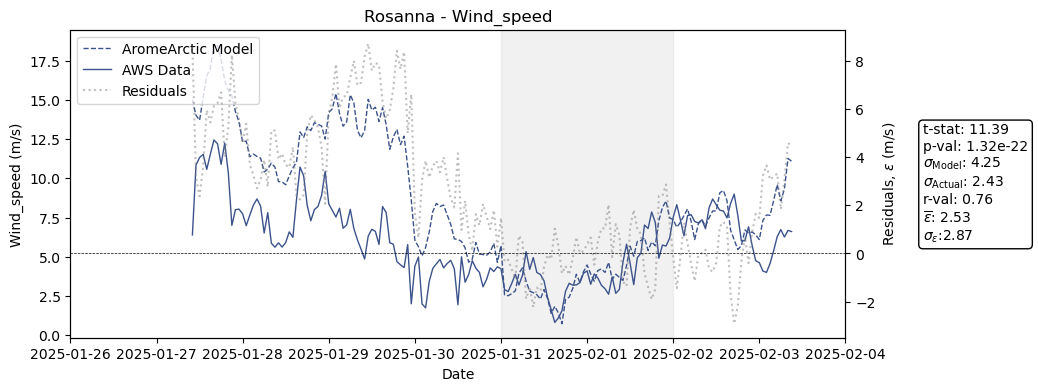

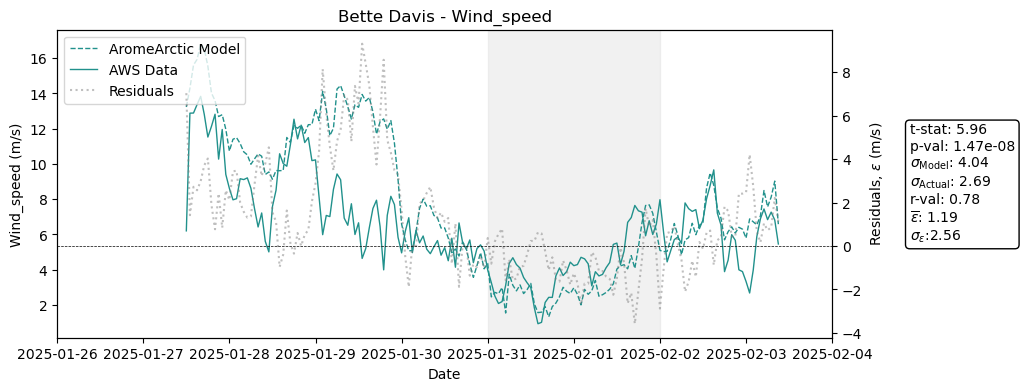

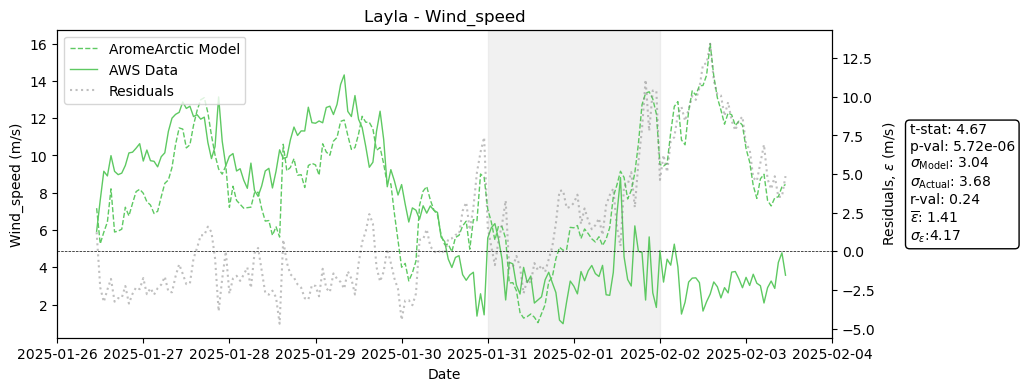

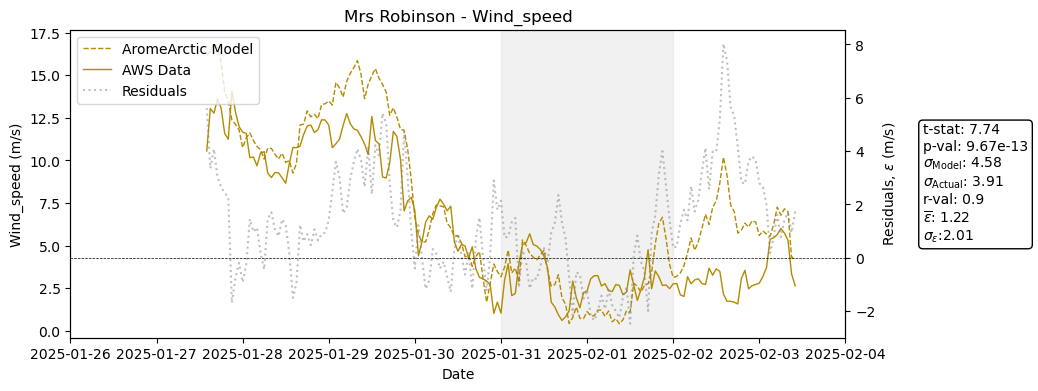

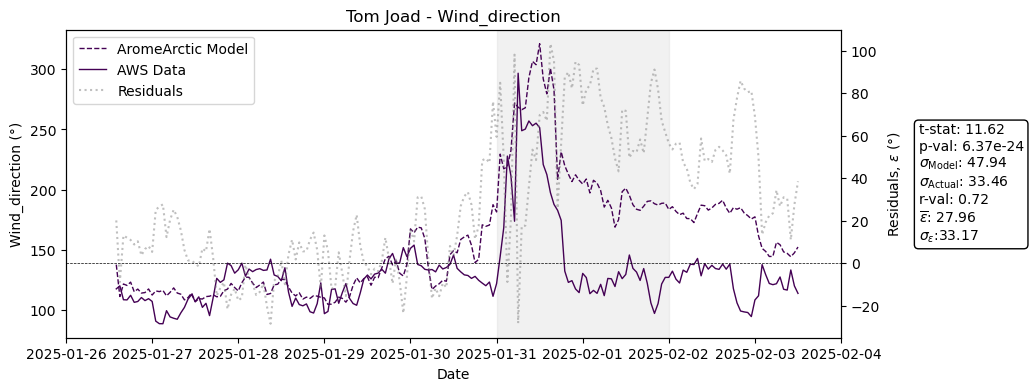

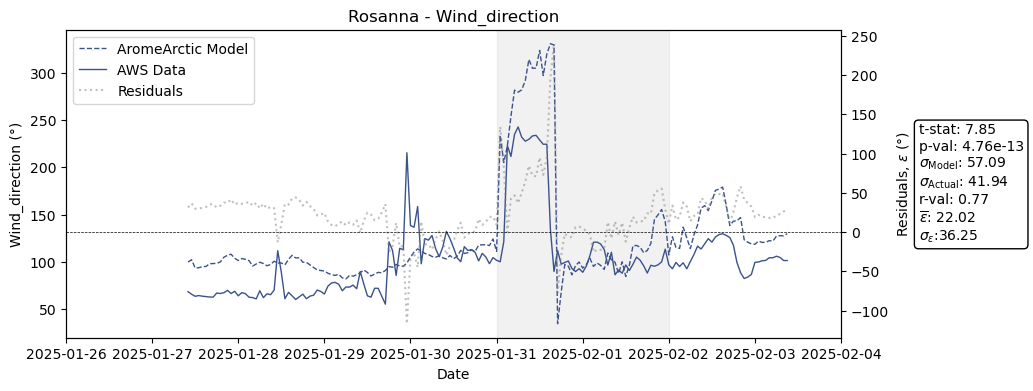

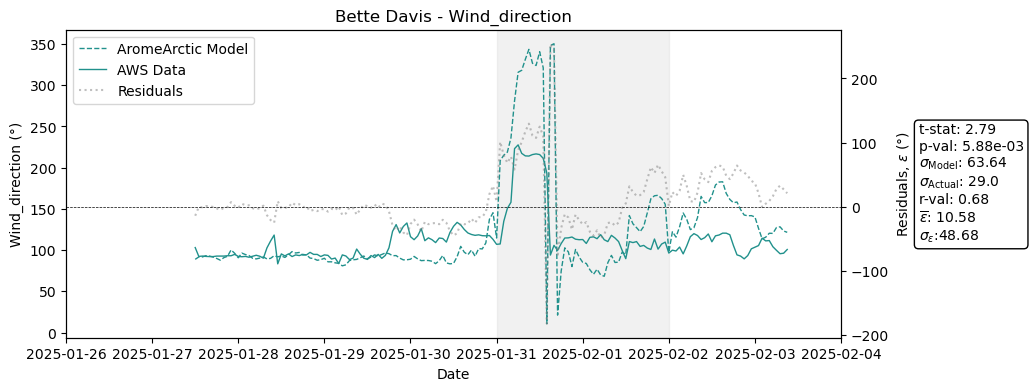

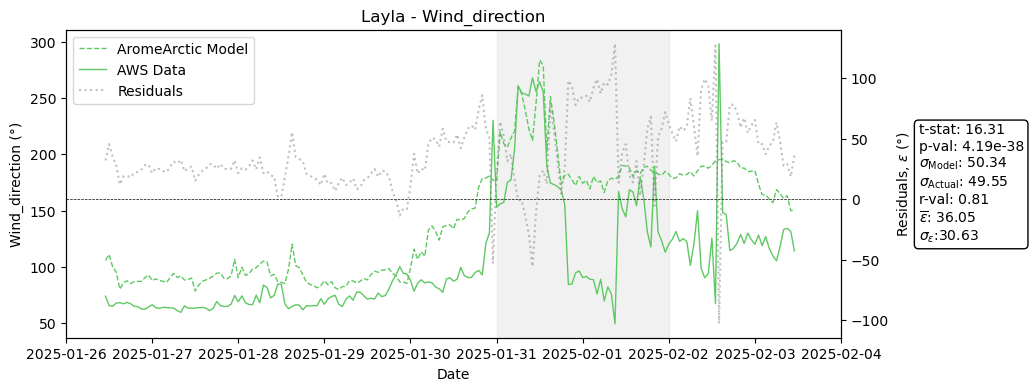

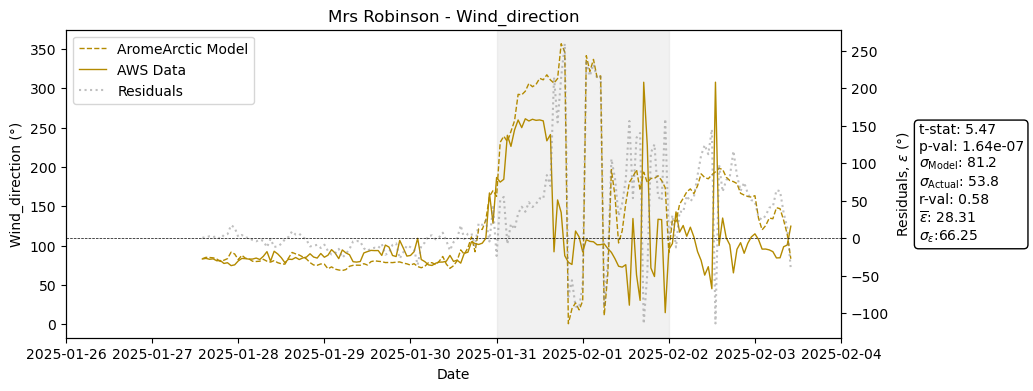

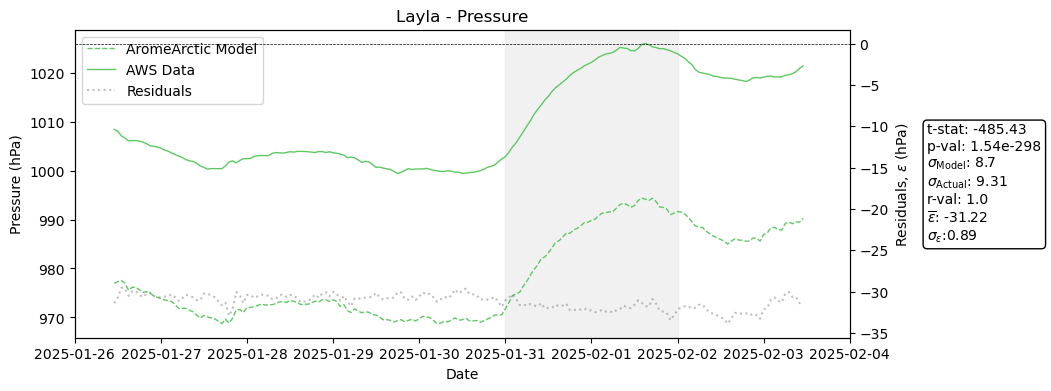

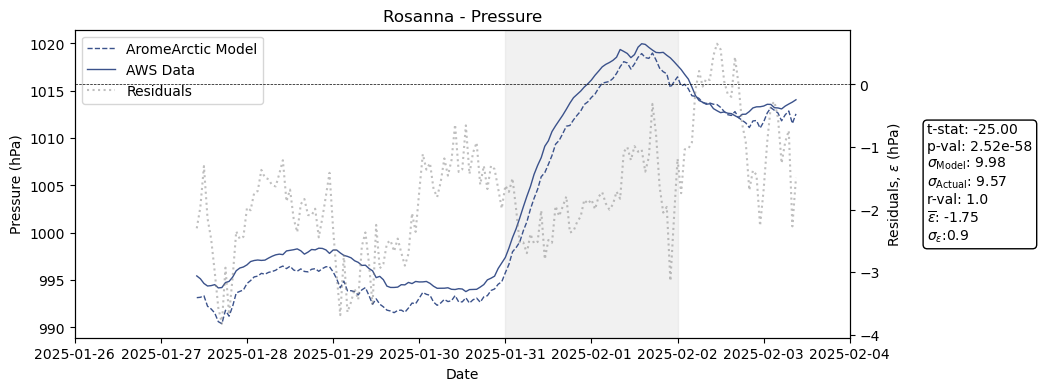

In [33]:
def plot_timeseries_with_residuals(variable):
    """
    Plots time series of AWS and model data for a given variable and overlays residuals on a secondary y-axis.
    Adds a shaded area for January 31st to February 1st.
    
    Parameters:
    - variable (str): "temperature", "wind_speed", "wind_direction", "pressure".
    
    Returns:
    - results (dict): Dictionary containing model data, actual data, residuals, and statistics for each station.
    """
    
    global aws_hourly_data, aromeArctic_data, instrument_textbook_data, color_idx, match_data_length

    stations_str = ['Tom Joad', 'Rosanna', 'Bette Davis', 'Layla', 'Mrs Robinson']
    stations_to_plot = ["Layla", "Rosanna"]  # Used for pressure only

    # Determine which stations to plot
    if variable == "pressure":
        stations = stations_to_plot
    else:
        stations = stations_str

    # Variable mappings
    variable_mapping = {
        "temperature": {"aws_key": "temperature", "arome_key": "air_temperature_2m", "unit": "°C", "convert": lambda x: x - 273.15},
        "wind_speed": {"aws_key": "calibrated_wind_speed", "arome_key": "wind_speed_10m", "unit": "m/s", "convert": lambda x: x},
        "wind_direction": {"aws_key": "wind_direction", "arome_key": "wind_direction_10m", "unit": "°", "convert": lambda x: x},
        "pressure": {"aws_key": "calibrated_air_pressure", "arome_key": "surface_air_pressure", "unit": "hPa", "convert": lambda x: x / 100},
    }

    if variable not in variable_mapping:
        raise ValueError(f"Invalid variable. Choose from {list(variable_mapping.keys())}")
    
    aws_key = variable_mapping[variable]["aws_key"]
    arome_key = variable_mapping[variable]["arome_key"]
    unit = variable_mapping[variable]["unit"]
    convert_func = variable_mapping[variable]["convert"]
    
    results = {}
    
    for i, station in enumerate(stations):
        fig, ax1 = plt.subplots(figsize=(10, 4))
        
        station_data = instrument_textbook_data[instrument_textbook_data["Station name"] == station]
        station_lat = station_data["LAT (dec deg)"].values[0]
        station_lon = station_data["LON (dec deg)"].values[0]
        
        # Find closest model grid point
        abs_diff = np.abs(aromeArctic_data.latitude - station_lat) + np.abs(aromeArctic_data.longitude - station_lon)
        abs_diff_np = abs_diff.values
        y_idx, x_idx = np.unravel_index(np.argmin(abs_diff_np), abs_diff_np.shape)
        
        timeseries = convert_func(aromeArctic_data[arome_key].isel(y=y_idx, x=x_idx))
        model_data = timeseries.to_series()
        actual_data = aws_hourly_data[station][aws_key]
        model_data, actual_data = match_data_length(model_data, actual_data)
        
        errors = model_data - actual_data
        stats = compute_t_stat(errors)
        r_value, _ = pearsonr(model_data, actual_data)
        r_value = round(r_value, 2)
        
        model_std = round(np.std(model_data), 2)
        actual_std = round(np.std(actual_data), 2)

        error_mean = round(np.mean(errors), 2)
        error_std = round(np.std(errors), 2)

        results[station] = {
            "model_data": model_data,
            "actual_data": actual_data,
            "errors": errors,
            "t-statistic": stats["tstat"],
            "p-value": stats["pval"],
            "r-value": r_value,
            "error_mean": error_mean,
            "error_std": error_std
        }

        # **Shaded Area (January 31st - February 1st)**
        start_date = pd.Timestamp("2025-01-31 00:00:00")
        end_date = pd.Timestamp("2025-02-02 00:00:00")
        ax1.axvspan(start_date, end_date, color='lightgray', alpha=0.3, label="Highlighted Period")

        # Left Y-Axis: Model vs. Actual Data
        if variable == "pressure":
            color_idx1 = ['#5ec962', '#3b528b']
            model_line, = ax1.plot(model_data.index, model_data, label='AromeArctic Model', linewidth=1, color=color_idx1[i], linestyle='--')
            actual_line, = ax1.plot(actual_data.index, actual_data, label='AWS Data', linewidth=1, color=color_idx1[i], linestyle='-')
        else:
            model_line, = ax1.plot(model_data.index, model_data, label='AromeArctic Model', linewidth=1, color=color_idx[i], linestyle='--')
            actual_line, = ax1.plot(actual_data.index, actual_data, label='AWS Data', linewidth=1, color=color_idx[i], linestyle='-')
        ax1.set_ylabel(f"{variable.capitalize()} ({unit})")
        ax1.set_xlabel("Date")

        # Right Y-Axis: Residuals
        ax2 = ax1.twinx()
        residual_line, = ax2.plot(actual_data.index, errors, color='grey', linestyle=':', alpha=0.5, label="Residuals")
        ax2.axhline(0, color='black', linewidth=0.5, linestyle='--')
        ax2.set_ylabel("Residuals, "r'$\epsilon$ ' f'({unit})')

        ax1.set_title(f"{station} - {variable.capitalize()}")

        ax1.set_xlim(pd.Timestamp("2025-01-26"), pd.Timestamp("2025-02-04"))

        # **Combine both legends**
        lines = [model_line, actual_line, residual_line]
        labels = [line.get_label() for line in lines]
        ax1.legend(lines, labels, loc="upper left")

        # **Display statistical summary**
        stats_text = (
            f"t-stat: {stats['tstat']:.2f}\n"
            f"p-val: {stats['pval']:.2e}\n"
            r"$\sigma_{\text{Model}}$: " f"{model_std}\n"
            r"$\sigma_{\text{Actual}}$: " f"{actual_std}\n"
            f'r-val: {r_value}\n'
            f'$\overline{{\epsilon}}$: {error_mean}\n'
            r'$\sigma_{\epsilon}$:' f'{error_std}'
        )
        ax1.text(1.1, 0.5, stats_text, transform=ax1.transAxes, fontsize=10,
                 verticalalignment='center', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

        save_figure(fig, '../figs/', f'modelValidation_{variable}_{station}')

    return results


# Generate plots for all variables with residuals and statistics
temp_data = plot_timeseries_with_residuals("temperature")
windSpeed_data = plot_timeseries_with_residuals("wind_speed")
windDirection_data = plot_timeseries_with_residuals("wind_direction")
pressure_data = plot_timeseries_with_residuals("pressure")


# Generating temperature anomaly array, for map stations

In [8]:
# # Extract station names (keep only prefix + number)
# instrument_textbook_data['Formatted Name'] = [
#     re.sub(r"(TT|TH|CEB)(\d+).*", r"\1\2", name) if re.match(r"(TT|TH|CEB)\d+", name) else name
#     for name in instrument_textbook_data['Station name']
# ]

# # Find duplicate names
# duplicates = instrument_textbook_data['Formatted Name'].value_counts()
# duplicate_names = duplicates[duplicates > 1].index  # Names that appear more than once

# # Apply "_low" and "_high" based on "Th height (m)"
# for name in duplicate_names:
#     subset = instrument_textbook_data[instrument_textbook_data['Formatted Name'] == name]
    
#     # Find the lowest and highest Th height
#     min_index = subset['Thermometer height (m)'].idxmin()
#     max_index = subset['Thermometer height (m)'].idxmax()
    
#     # Rename them
#     instrument_textbook_data.loc[min_index, 'Formatted Name'] = f"{name}_low"
#     instrument_textbook_data.loc[max_index, 'Formatted Name'] = f"{name}_high"

# # Get final formatted list
# formatted_names = instrument_textbook_data['Formatted Name'].tolist()

# instrument_textbook_data.insert(0, 'Formatted Station Name', instrument_textbook_data.pop('Formatted Name'))

# # TinyTag_str = [s for s in formatted_names if s.startswith(("TT", "TH", "CEB"))]
# TinyTag_str = [s for s in formatted_names if s.startswith(("TH"))]


# TinyTag_str

In [9]:
#function from unis github
def read_Tinytag(filename, sensor):
    '''
    Reads data from one or several data files from the Tinytag output files.

    Parameters:
    -------
    filename: str
        String with path to file(s)
        If several files shall be read, specify a string including UNIX-style wildcards
    sensor: str
        One of "TT", "TH" or "CEB"
    Returns
    -------
    df : pandas dataframe
        a pandas dataframe with time as index and the individual variables as columns.
    '''

    import dask.dataframe as ddf


    if sensor == "TT":
        df = ddf.read_csv(filename, delimiter="\t", skiprows=5, parse_dates=[1], date_format="%d %b %Y %H:%M:%S", names=["RECORD", "TIMESTAMP", "T_black", "T_white"], encoding = "ISO-8859-1")
    elif sensor == "TH":
        df = ddf.read_csv(filename, delimiter="\t", skiprows=5, parse_dates=[1], date_format="%d %b %Y %H:%M:%S", names=["RECORD", "TIMESTAMP", "T", "RH"], encoding = "ISO-8859-1")
    elif sensor == "CEB":
        df = ddf.read_csv(filename, delimiter="\t", skiprows=5, parse_dates=[1], date_format="%d %b %Y %H:%M:%S", names=["RECORD", "TIMESTAMP", "T"], encoding = "ISO-8859-1")
    else:
        assert False, 'Sensortype of Tinytag not known. Should be one of "TT", "TH" or "CEB".'

    df = df.compute()
    df.set_index("TIMESTAMP", inplace=True)

    for key in list(df.columns):
        if key == "RECORD":
            pass
        else:
            data = [float(i.split(" ")[0]) for i in df[key]]
            unit = df[key].iloc[0].split(" ")[1]
            if unit == "°C":
                unit = "degC"
            new_key = f"{key}_{unit}"

            df[new_key] = data

            df.drop(key, axis=1, inplace=True)

    return df

In [10]:
# TinyTag_str = ['TH1_normal_data_calibrated_data.csv', 'TH2_normal_data_calibrated_data.csv', 'TH3_normal_data_calibrated_data.csv', 'TH5_normal_data_calibrated_data.csv', 'TH6_normal_data_calibrated_data.csv', 'TH8_normal_data_calibrated_data.csv']

In [11]:
tinytag_path = load_path() + 'CalibratedData/TinyTag/'


# Get all CSV files in the folder
csv_files = glob.glob(os.path.join(tinytag_path, "*.csv"))

# Dictionary to store DataFrames
TinyTag_data = {}

# Load each CSV file into a DataFrame
for file in csv_files:
    file_name = os.path.basename(file)  # Extract filename without path
    TinyTag_data[file_name] = pd.read_csv(file)  # Load CSV into dictionary


In [12]:

# List of valid station names
TinyTag_str = ['TH1', 'TH2', 'TH3', 'TH5', 'TH6', 'TH8']

# Dictionary to store transformed DataFrames
transformed_data = {}

for file_name, df in TinyTag_data.items():
    # Extract station name (TH1, TH2, etc.) from file_name
    match = re.search(r"TH\d+", file_name)
    
    if match:
        station_name = match.group(0)  # Extract matched station (e.g., "TH1")

        if station_name in TinyTag_str:
            # Convert TIMESTAMP to datetime and set as index
            df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"])
            df = df.set_index("TIMESTAMP")

            # Store transformed DataFrame with proper station name
            transformed_data[station_name] = df

# Replace TinyTag_data with the transformed version
TinyTag_data = transformed_data

print("TinyTag_data is now structured correctly for resampling!")


TinyTag_data is now structured correctly for resampling!


In [13]:
tinytag_hourly_data = {}

for i, station in enumerate(TinyTag_str):
    tinytag_hourly_data[station] = TinyTag_data[station].resample('h').mean()
    # Add a column for station name
    tinytag_hourly_data[station]['Station'] = station 

In [14]:
# Initialize dictionaries for storing results
tinytag_model_data = {}
actual_tinytag_data = {}
tinytag_errors = {}

# Variable for temperature (TinyTag vs. Arome Arctic model)
tinytag_arome_key = "air_temperature_2m"

for station in TinyTag_str:
    # Get TinyTag station data
    if station not in instrument_textbook_data["Station name"].values:
        print(f"Warning: No coordinate data for {station}, skipping.")
        continue
    
    station_data = instrument_textbook_data[instrument_textbook_data["Station name"] == station]
    station_lat = station_data["LAT (dec deg)"].values[0]
    station_lon = station_data["LON (dec deg)"].values[0]

    # Find closest Arome Arctic model grid point
    abs_diff = np.abs(aromeArctic_data.latitude - station_lat) + np.abs(aromeArctic_data.longitude - station_lon)
    abs_diff_np = abs_diff.values
    y_idx, x_idx = np.unravel_index(np.argmin(abs_diff_np), abs_diff_np.shape)

    # Extract model temperature data at nearest grid point (Convert K to °C)
    model_timeseries = aromeArctic_data[tinytag_arome_key].isel(y=y_idx, x=x_idx) - 273.15
    model_data = model_timeseries.to_series()

    # Get TinyTag actual data (using "Calibrated_Temperature")
    if station in tinytag_hourly_data:
        actual_data = tinytag_hourly_data[station]["Calibrated_Temperature"]
    else:
        print(f"Warning: No TinyTag temperature data for {station}, skipping.")
        continue

    # Match model data and actual data time indexes
    model_data, actual_data = match_data_length(model_data, actual_data)

    # Compute residuals (model - actual)
    errors = model_data - actual_data

    # Store results
    tinytag_model_data[station] = model_data
    actual_tinytag_data[station] = actual_data
    tinytag_errors[station] = errors

print("TinyTag model data, actual data, and errors successfully computed!")


TinyTag model data, actual data, and errors successfully computed!


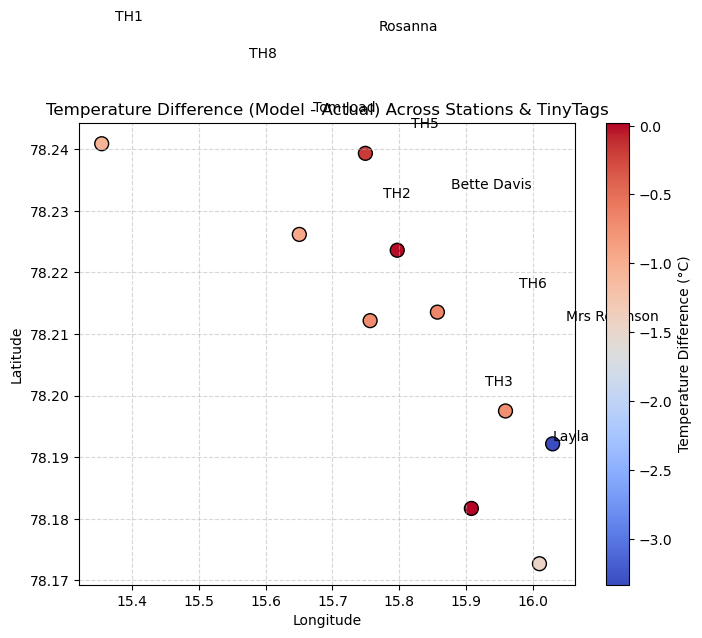

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists for storing station data
lats = []
lons = []
temp_diffs = []

# Combine AWS stations and TinyTag stations
all_stations = stations_str + TinyTag_str

for station in all_stations:
    station_data = instrument_textbook_data[instrument_textbook_data["Station name"] == station]
    
    if station_data.empty:
        continue  # Skip if no data for the station
    
    # Extract latitude and longitude
    lat = station_data["LAT (dec deg)"].values[0]
    lon = station_data["LON (dec deg)"].values[0]
    
    # Compute mean temperature difference (Model - Actual)
    if station in temp_data:
        temp_diff = np.mean(temp_data[station]['errors'])  # AWS station data
    elif station in tinytag_errors:
        temp_diff = np.mean(tinytag_errors[station])  # TinyTag station data
    else:
        continue  # Skip if no temperature data available

    # Append extracted data
    lats.append(lat)
    lons.append(lon)
    temp_diffs.append(temp_diff)

# Convert lists to numpy arrays
lats = np.array(lats)
lons = np.array(lons)
temp_diffs = np.array(temp_diffs)

# Create scatter plot
fig, ax = plt.subplots(figsize=(8, 6))

sc = ax.scatter(lons, lats, c=temp_diffs, cmap='coolwarm', edgecolors='black', s=100)

# Add color bar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Temperature Difference (°C)")

# Set labels and title
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Temperature Difference (Model - Actual) Across Stations & TinyTags")

# Add station names next to points
for i, station in enumerate(all_stations):
    ax.text(lons[i] + 0.02, lats[i] + 0.02, station, fontsize=10, ha='left')

# Show plot
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


In [24]:
# # Extract latitude, longitude, and temperature residuals for each station
# lats = []
# lons = []
# temp_diffs = []

# for station in stations_str:
#     station_data = instrument_textbook_data[instrument_textbook_data["Station name"] == station]
    
#     if station_data.empty:
#         continue  # Skip if no data for the station
    
#     lat = station_data["LAT (dec deg)"].values[0]
#     lon = station_data["LON (dec deg)"].values[0]
    
#     # actual_data = temp_data[station]['actual_data']
#     # model_data = temp_data[station]['model_data']

    
#     # # Compute the mean temperature difference (model - actual)
#     # temp_diff = np.mean(model_data - actual_data)

#     temp_diff = np.mean(temp_data[station]['errors'])

    
#     lats.append(lat)
#     lons.append(lon)
#     temp_diffs.append(temp_diff)

# # Convert to numpy arrays
# lats = np.array(lats)
# lons = np.array(lons)
# temp_diffs = np.array(temp_diffs)

# # Create scatter plot
# fig, ax = plt.subplots(figsize=(8, 6))

# sc = ax.scatter(lons, lats, c=temp_diffs, cmap='coolwarm', edgecolors='black', s=100)

# # Add color bar
# cbar = plt.colorbar(sc, ax=ax)
# cbar.set_label("Temperature Difference (°C)")

# # Set labels and title
# ax.set_xlabel("Longitude")
# ax.set_ylabel("Latitude")
# ax.set_title("Temperature Difference (Model - Actual) Across Stations")

# # Add station names next to points
# for i, station in enumerate(stations_str):
#     ax.text(lons[i] + 0.02, lats[i] + 0.02, station, fontsize=10, ha='left')

# # Show plot
# plt.grid(True, linestyle="--", alpha=0.5)
# plt.show()



In [17]:
#TESTETSTETS

In [18]:
temp_diffs_df = pd.DataFrame({
    "Station Name": stations_str,
    "Temperature Difference (°C)": temp_diffs
})

# Save to CSV file
csv_filename = load_path() + "temperature_differences.csv"
temp_diffs_df.to_csv(csv_filename, index=False)

# print(f"CSV file saved as {csv_filename}")

# Comute Residuals

<>:23: SyntaxWarning: invalid escape sequence '\o'
<>:23: SyntaxWarning: invalid escape sequence '\e'
<>:23: SyntaxWarning: invalid escape sequence '\s'
<>:23: SyntaxWarning: invalid escape sequence '\o'
<>:23: SyntaxWarning: invalid escape sequence '\e'
<>:23: SyntaxWarning: invalid escape sequence '\s'
C:\Users\alber\AppData\Local\Temp\ipykernel_21844\519649200.py:23: SyntaxWarning: invalid escape sequence '\o'
  ax.text(0.02, 0.95, f"$\overline{{\epsilon}}$: {error_mean:.2f}\n$\sigma$: {error_std:.2f}",
C:\Users\alber\AppData\Local\Temp\ipykernel_21844\519649200.py:23: SyntaxWarning: invalid escape sequence '\e'
  ax.text(0.02, 0.95, f"$\overline{{\epsilon}}$: {error_mean:.2f}\n$\sigma$: {error_std:.2f}",
C:\Users\alber\AppData\Local\Temp\ipykernel_21844\519649200.py:23: SyntaxWarning: invalid escape sequence '\s'
  ax.text(0.02, 0.95, f"$\overline{{\epsilon}}$: {error_mean:.2f}\n$\sigma$: {error_std:.2f}",


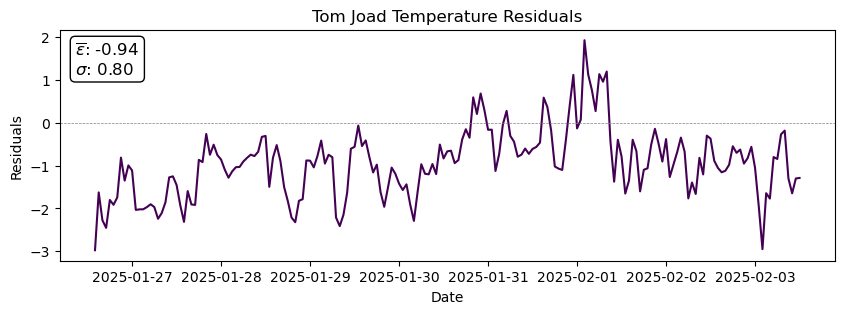

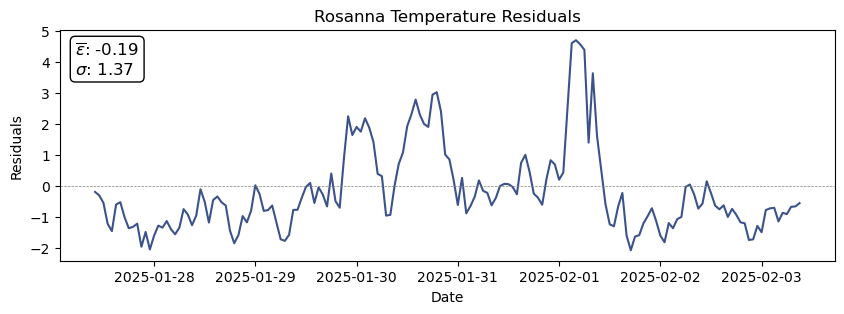

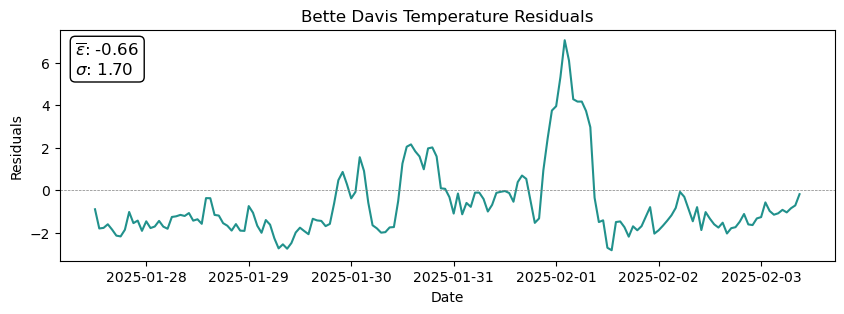

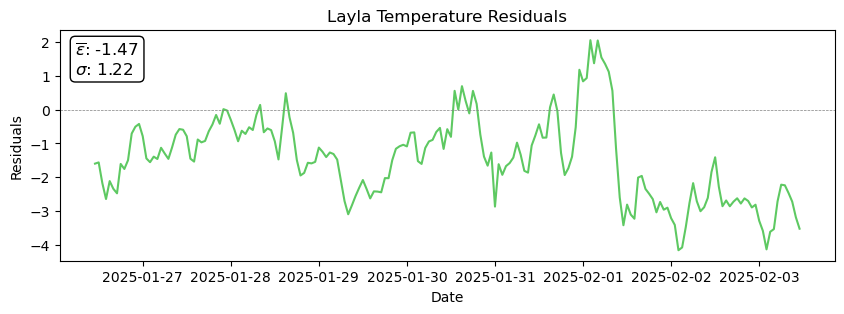

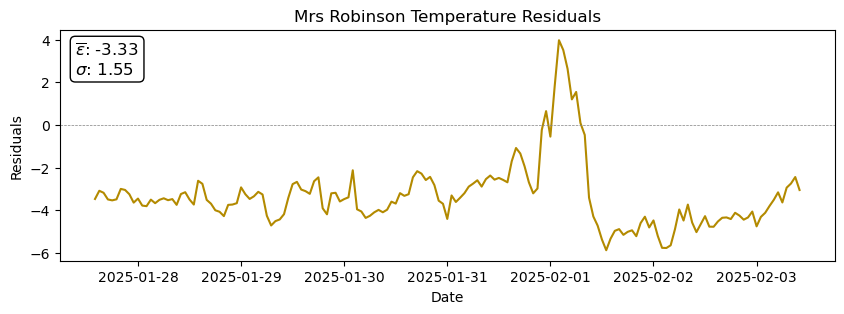

In [19]:
# Compute statistics

for i, station in enumerate(stations_str):

    error_mean = np.mean(temp_data[station]['errors'])
    error_std = np.std(temp_data[station]['errors'])

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 3))

    # Plot errors
    ax.plot(temp_data[station]['actual_data'].index, temp_data[station]['errors'], color=color_idx[i], label="Bias")

    # Add horizontal line at 0
    ax.axhline(0, color='grey', linewidth=0.5, linestyle='--')

    # Set labels and title
    ax.set_title(f'{station} Temperature Residuals')
    ax.set_xlabel('Date')
    ax.set_ylabel('Residuals')

    # Display mean and std as text on the plot
    ax.text(0.02, 0.95, f"$\overline{{\epsilon}}$: {error_mean:.2f}\n$\sigma$: {error_std:.2f}", 
            transform=ax.transAxes, fontsize=12, verticalalignment='top', 
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))



    save_figure(fig, '../figs/', f'residuals_temperature_{station}')

# Show plot
# plt.legend()
# plt.grid()
# plt.show()


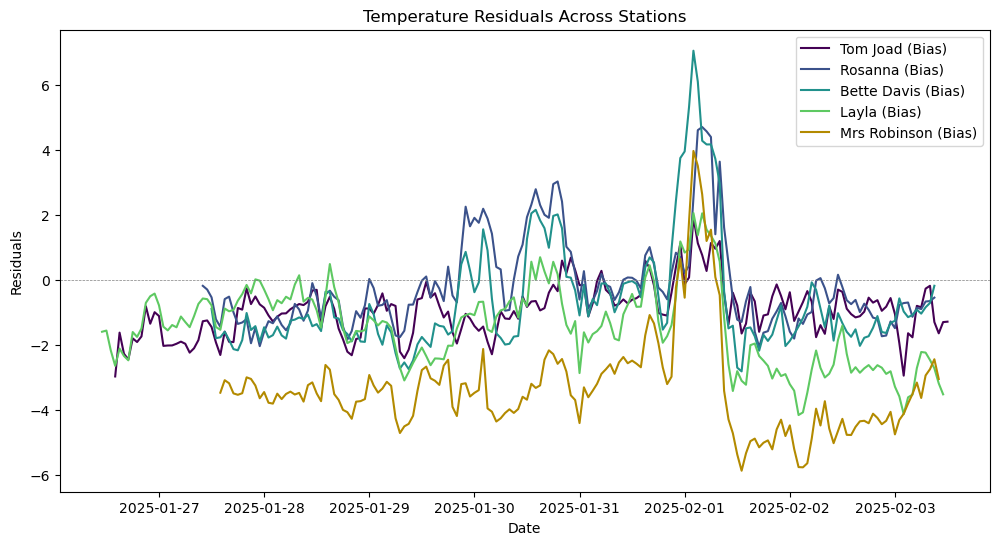

In [20]:
# Create a single figure
fig, ax = plt.subplots(figsize=(12, 6))

# Compute statistics and plot all residuals on the same figure
for i, station in enumerate(stations_str):
    error_mean = np.mean(temp_data[station]['errors'])
    error_std = np.std(temp_data[station]['errors'])

    # Plot errors for each station
    ax.plot(temp_data[station]['actual_data'].index, 
            temp_data[station]['errors'], 
            color=color_idx[i], 
            label=f"{station} (Bias)")

# Add horizontal line at 0
ax.axhline(0, color='grey', linewidth=0.5, linestyle='--')

# Set labels and title
ax.set_title('Temperature Residuals Across Stations')
ax.set_xlabel('Date')
ax.set_ylabel('Residuals')

# Add legend
ax.legend()

# Show grid
# ax.grid(True, linestyle='--', alpha=0.5)

# Show plot
plt.show()


<>:21: SyntaxWarning: invalid escape sequence '\o'
<>:21: SyntaxWarning: invalid escape sequence '\e'
<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\o'
<>:21: SyntaxWarning: invalid escape sequence '\e'
<>:21: SyntaxWarning: invalid escape sequence '\s'
C:\Users\alber\AppData\Local\Temp\ipykernel_21844\2382465053.py:21: SyntaxWarning: invalid escape sequence '\o'
  ax.text(0.02, 0.95, f"$\overline{{\epsilon}}$: {error_mean:.2f}\n$\sigma$: {error_std:.2f}",
C:\Users\alber\AppData\Local\Temp\ipykernel_21844\2382465053.py:21: SyntaxWarning: invalid escape sequence '\e'
  ax.text(0.02, 0.95, f"$\overline{{\epsilon}}$: {error_mean:.2f}\n$\sigma$: {error_std:.2f}",
C:\Users\alber\AppData\Local\Temp\ipykernel_21844\2382465053.py:21: SyntaxWarning: invalid escape sequence '\s'
  ax.text(0.02, 0.95, f"$\overline{{\epsilon}}$: {error_mean:.2f}\n$\sigma$: {error_std:.2f}",


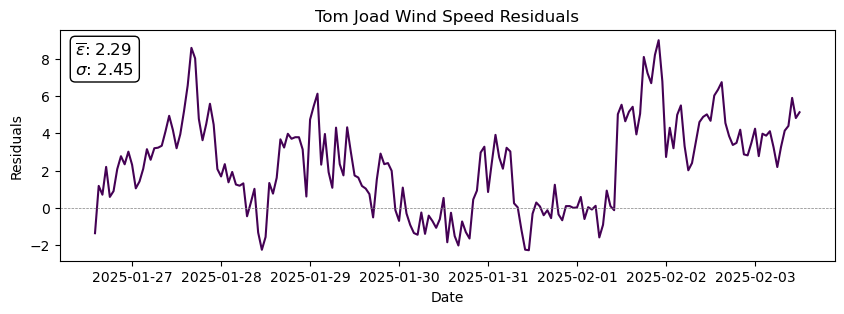

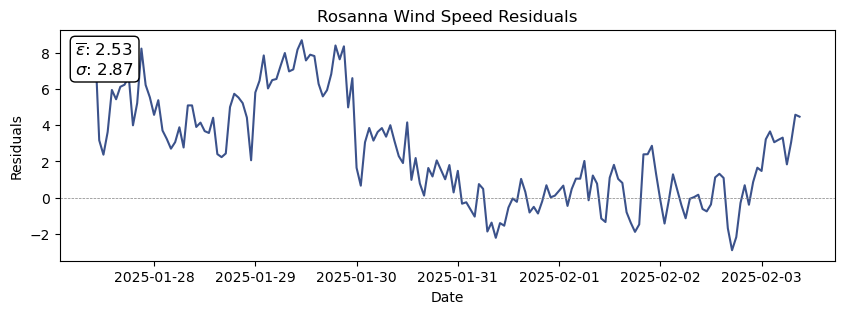

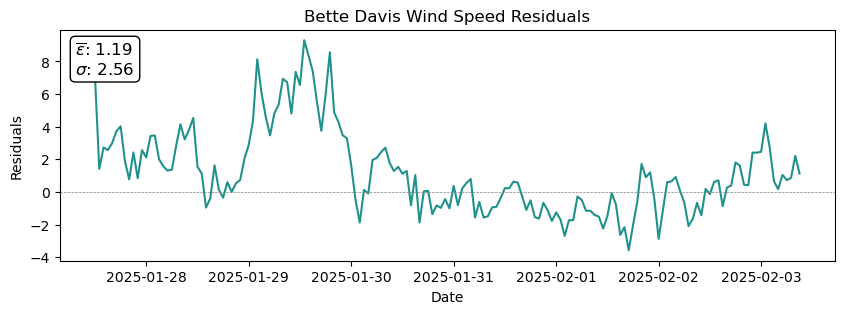

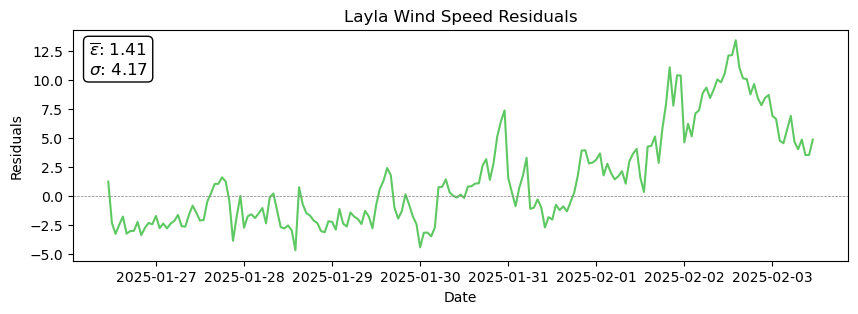

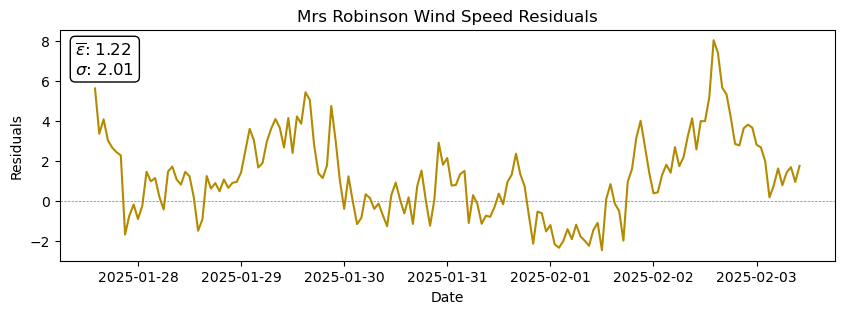

In [21]:

for i, station in enumerate(stations_str):

    error_mean = np.mean(windSpeed_data[station]['errors'])
    error_std = np.std(windSpeed_data[station]['errors'])

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 3))

    # Plot errors
    ax.plot(windSpeed_data[station]['actual_data'].index, windSpeed_data[station]['errors'], color=color_idx[i], label="Bias")

    # Add horizontal line at 0
    ax.axhline(0, color='grey', linewidth=0.5, linestyle='--')

    # Set labels and title
    ax.set_title(f'{station} Wind Speed Residuals')
    ax.set_xlabel('Date')
    ax.set_ylabel('Residuals')

    # Display mean and std as text on the plot
    ax.text(0.02, 0.95, f"$\overline{{\epsilon}}$: {error_mean:.2f}\n$\sigma$: {error_std:.2f}", 
            transform=ax.transAxes, fontsize=12, verticalalignment='top', 
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

    save_figure(fig, '../figs/', f'residuals_windSpeed_{station}')


<>:21: SyntaxWarning: invalid escape sequence '\o'
<>:21: SyntaxWarning: invalid escape sequence '\e'
<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\o'
<>:21: SyntaxWarning: invalid escape sequence '\e'
<>:21: SyntaxWarning: invalid escape sequence '\s'
C:\Users\alber\AppData\Local\Temp\ipykernel_21844\3019210909.py:21: SyntaxWarning: invalid escape sequence '\o'
  ax.text(0.02, 0.95, f"$\overline{{\epsilon}}$: {error_mean:.2f}\n$\sigma$: {error_std:.2f}",
C:\Users\alber\AppData\Local\Temp\ipykernel_21844\3019210909.py:21: SyntaxWarning: invalid escape sequence '\e'
  ax.text(0.02, 0.95, f"$\overline{{\epsilon}}$: {error_mean:.2f}\n$\sigma$: {error_std:.2f}",
C:\Users\alber\AppData\Local\Temp\ipykernel_21844\3019210909.py:21: SyntaxWarning: invalid escape sequence '\s'
  ax.text(0.02, 0.95, f"$\overline{{\epsilon}}$: {error_mean:.2f}\n$\sigma$: {error_std:.2f}",


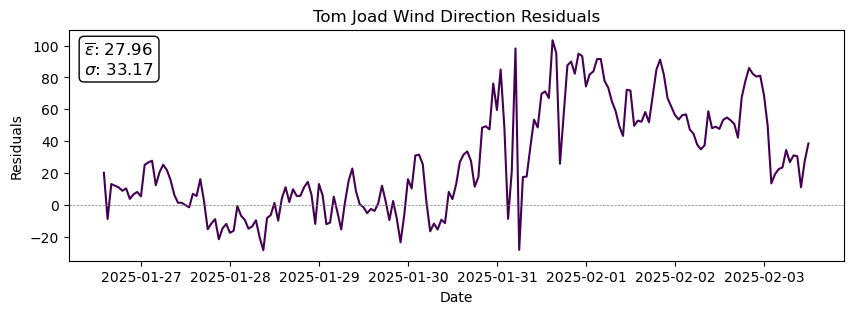

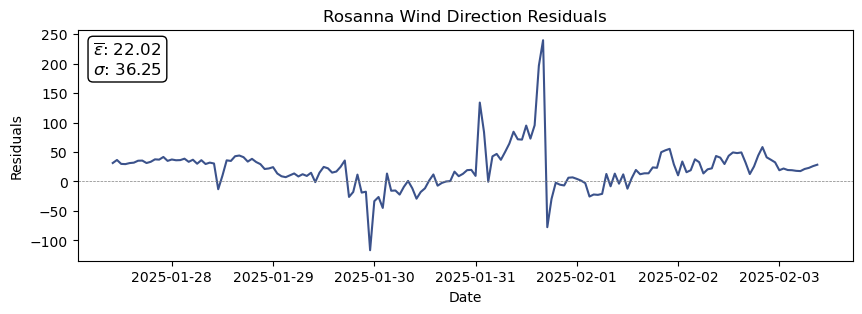

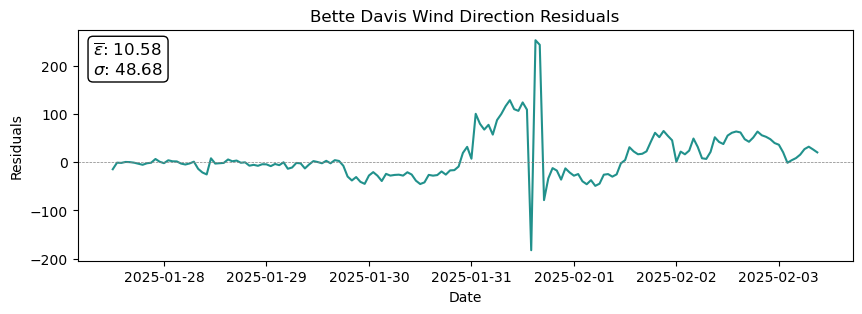

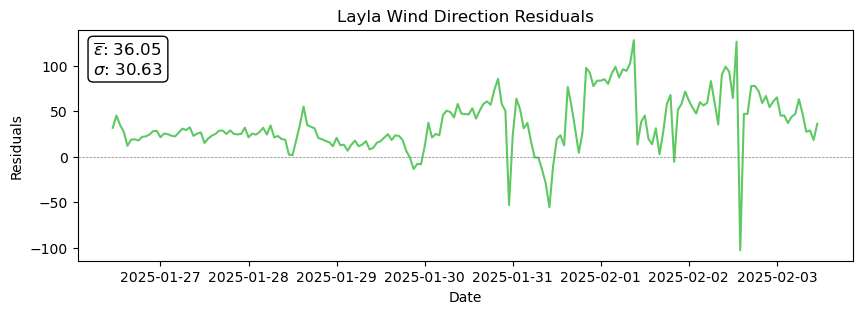

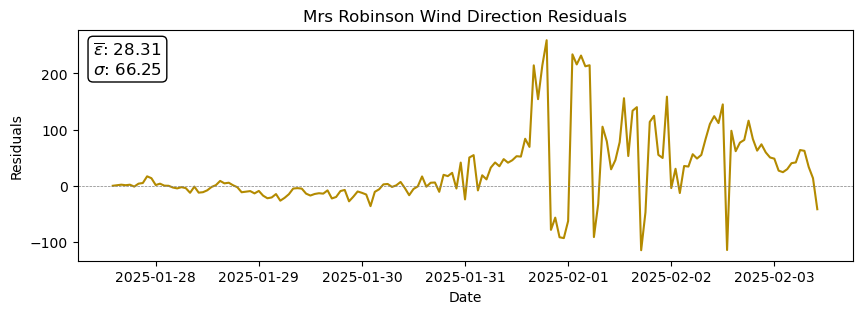

In [22]:

for i, station in enumerate(stations_str):

    error_mean = np.mean(windDirection_data[station]['errors'])
    error_std = np.std(windDirection_data[station]['errors'])

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 3))

    # Plot errors
    ax.plot(windDirection_data[station]['actual_data'].index, windDirection_data[station]['errors'], color=color_idx[i], label="Bias")

    # Add horizontal line at 0
    ax.axhline(0, color='grey', linewidth=0.5, linestyle='--')

    # Set labels and title
    ax.set_title(f'{station} Wind Direction Residuals')
    ax.set_xlabel('Date')
    ax.set_ylabel('Residuals')

    # Display mean and std as text on the plot
    ax.text(0.02, 0.95, f"$\overline{{\epsilon}}$: {error_mean:.2f}\n$\sigma$: {error_std:.2f}", 
            transform=ax.transAxes, fontsize=12, verticalalignment='top', 
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

    save_figure(fig, '../figs/', f'residuals_windDirection_{station}')

<>:21: SyntaxWarning: invalid escape sequence '\o'
<>:21: SyntaxWarning: invalid escape sequence '\e'
<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\o'
<>:21: SyntaxWarning: invalid escape sequence '\e'
<>:21: SyntaxWarning: invalid escape sequence '\s'
C:\Users\alber\AppData\Local\Temp\ipykernel_21844\2803491999.py:21: SyntaxWarning: invalid escape sequence '\o'
  ax.text(0.02, 0.95, f"$\overline{{\epsilon}}$: {error_mean:.2f}\n$\sigma$: {error_std:.2f}",
C:\Users\alber\AppData\Local\Temp\ipykernel_21844\2803491999.py:21: SyntaxWarning: invalid escape sequence '\e'
  ax.text(0.02, 0.95, f"$\overline{{\epsilon}}$: {error_mean:.2f}\n$\sigma$: {error_std:.2f}",
C:\Users\alber\AppData\Local\Temp\ipykernel_21844\2803491999.py:21: SyntaxWarning: invalid escape sequence '\s'
  ax.text(0.02, 0.95, f"$\overline{{\epsilon}}$: {error_mean:.2f}\n$\sigma$: {error_std:.2f}",


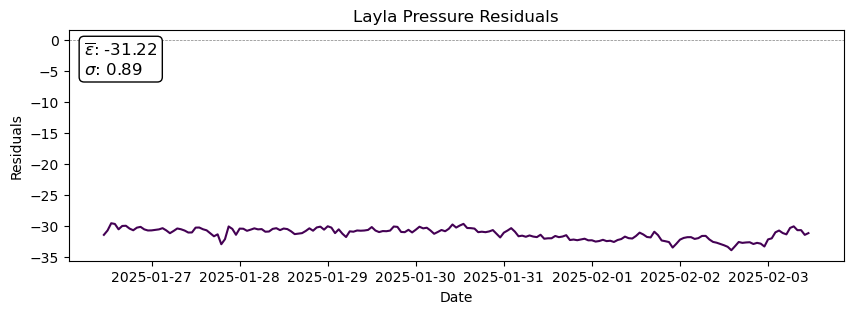

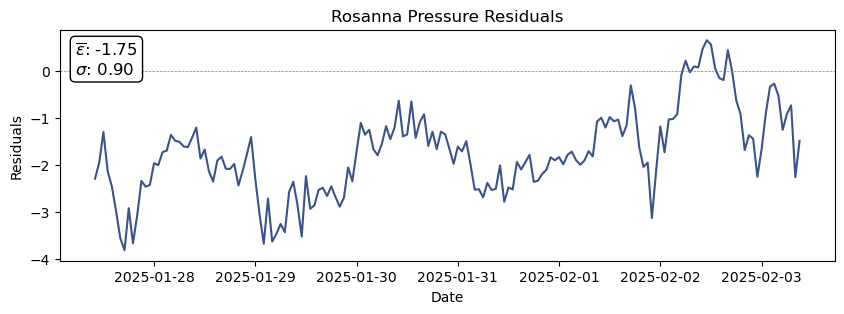

In [23]:
for i, station in enumerate(stations_to_plot):

    error_mean = np.mean(pressure_data[station]['errors'])
    error_std = np.std(pressure_data[station]['errors'])

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 3))

    # Plot errors
    ax.plot(pressure_data[station]['actual_data'].index, pressure_data[station]['errors'], color=color_idx[i], label="Bias")

    # Add horizontal line at 0
    ax.axhline(0, color='grey', linewidth=0.5, linestyle='--')

    # Set labels and title
    ax.set_title(f'{station} Pressure Residuals')
    ax.set_xlabel('Date')
    ax.set_ylabel('Residuals')

    # Display mean and std as text on the plot
    ax.text(0.02, 0.95, f"$\overline{{\epsilon}}$: {error_mean:.2f}\n$\sigma$: {error_std:.2f}", 
            transform=ax.transAxes, fontsize=12, verticalalignment='top', 
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

    save_figure(fig, '../figs/', f'residuals_pressure_{station}')